<a href="https://colab.research.google.com/github/JuanJGalindo/ML-Theory/blob/main/1FaceMetricsComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tarea y Contexto**

A continuación, se propone implementar un modelo computacional que compare la similitud entre rostros a través de métricas lineales.

El código se dividirá en las siguientes tareas:

*   Carga de Imágenes en Blanco y Negro
*   Redimensionamiento de Imágenes y Normalización
*   Cálculo de Métricas de Relevancia en Función de un Rostro de Referencia.
*   Visualización de Resultados

Las métricas en cuestión son las siguientes:

1.   **Distancia Euclídea:** Medida de diferencia absoluta entre vectores en el espacio de características. Mide diferencias absolutas de píxeles o embeddings. Es sencilla, pero sensible a cambios de iluminación o escala.

$$d(\mathbf{a},\mathbf{b}) = \sqrt{\sum_{i=1}^{n} (a_i - b_i)^2}$$

2.   **Similaridad del Coseno:** Mide el ángulo entre dos vectores, ignorando su magnitud. Útil cuando importa la dirección del patrón pero no la escala (ej: iluminación distinta en una foto). Robusta ante cambios de escala/iluminación.

$$\text{sim}_{\cos}(\mathbf{a},\mathbf{b}) = \frac{\mathbf{a}\cdot \mathbf{b}}{\|\mathbf{a}\| \, \|\mathbf{b}\|}$$


3.   **Coeficiente de Correlación de Pearson:** Evalúa la dependencia lineal entre dos vectores. Considera tanto la media como la variación relativa. Útil cuando queremos medir si los rostros “varían en paralelo” (ej: expresiones distintas pero misma persona).

$$\rho(\mathbf{a},\mathbf{b}) = \frac{\sum_{i=1}^{n} (a_i - \bar{a})(b_i - \bar{b})} {\sqrt{\sum_{i=1}^{n} (a_i - \bar{a})^2} \; \sqrt{\sum_{i=1}^{n} (b_i - \bar{b})^2}}$$








# **Implementación de Funciones**

In [134]:
# Library Import
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image

# Image Loading, Resizing and Normalization Helper Function
def loadImage(path, size=(256, 256)):
  "Load image, convert to grayscale, resize and normalize"
  img = Image.open(path).convert("L")             # Load and Grayscale
  img = img.resize(size)                          # Resizing
  arr = np.array(img, dtype=np.float32) / 255.0   # Normalizing
  return arr.flatten()

# Image Displaying Helper Function
def showImagesGrid(paths, size=(256, 256)):
    """
    Load 5 images from paths, convert to grayscale, resize, and plot in a grid.
    """
    fig, axes = plt.subplots(1, len(paths), figsize=(15, 4))

    for i, path in enumerate(paths):
        img = Image.open(path).convert("L")   # Grayscale
        img = img.resize(size)                # Resize

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Euclidean Distance
def euclideanDistance(a, b):
    return np.linalg.norm(a - b)

# Cosine Similarity
def cosineSimilarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Pearson Correlation Coefficient
def pearsonCorrelation(a, b):
  return np.corrcoef(a, b)[0, 1]

# **Programa Principal**

In [135]:
# Images' Path
paths = ["/content/face1.jpeg",
         "/content/face2.jpeg",
         "/content/face3.jpeg",
         "/content/face4.jpeg",
         "/content/mama.jpg",]

# Images Array Construction
images = [loadImage(path) for path in paths]

# Metrics Calculation
euclideanDist = [euclideanDistance(images[0], img) for img in images]
cosineSim = [cosineSimilarity(images[0], img) for img in images]
pearsonCoef = [pearsonCorrelation(images[0], img) for img in images]

# **Análisis**

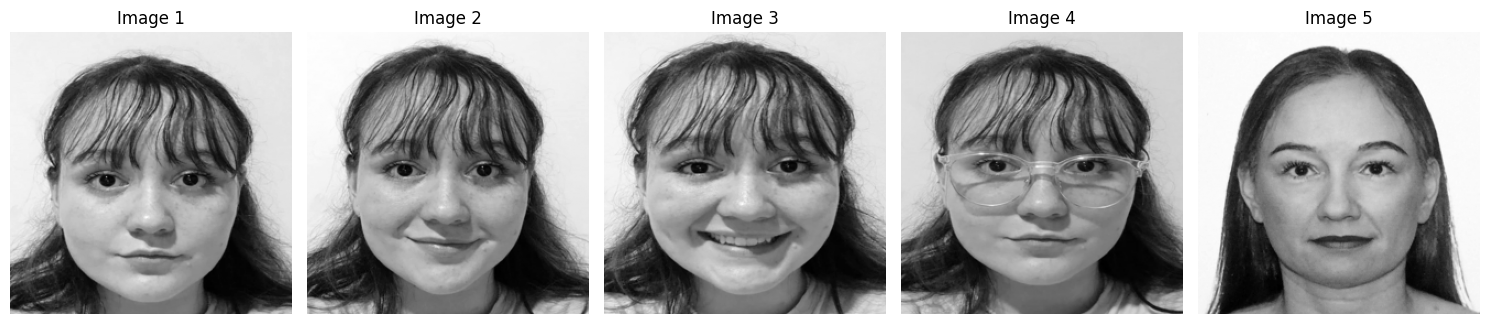

,Image 1,Image 2,Image 3,Image 4,Image 5
Euclidean Distance,0.00,41.19,51.29,49.90,53.51
Cosine Similarity,1.00,0.96,0.94,0.94,0.93
Pearson Correlation,1.00,0.82,0.67,0.69,0.62


In [136]:
import pandas as pd

# Crear DataFrame
df = pd.DataFrame(
    [euclideanDist, cosineSim, pearsonCoef],
    index=["Euclidean Distance", "Cosine Similarity", "Pearson Correlation"],
    columns=[f"Image {i}" for i in range(1, 6)]
)

# Image Display
showImagesGrid(paths)

# Metrics Display
df.style.set_caption("Metrics Comparison per Image")\
         .format("{:.2f}")\
         .background_gradient(cmap="PuRd", axis=1)

Tomando como referencia la Imagen 1, cada una de las métricas miden el parecido entre rostros de forma aproximadamente igual a la forma en la que compararíamos cada rostro de forma visual, al menos según una tendencia, si bien no desde el punto de vista de, qué tanto se parecerá si le diéramos una calificación de 0 a 10.

Así tendríamos desde la referencia hasta el rostro que menos se parece en el siguiente orden: Imagen 1, Imagen 2, Imagen 4, Imagen 3 e Imagen 5.

# **Continuación Tarea**


1.   Calcular la Proyección Lineal de dos imágenes de forma analítica.
2.   Calcular la Proyección Lineal de dos imágenes de forma iterativa.

Ambas tareas se hacen minimizando los mínimos cuadrados entre vectores.
Se hace uso del algoritmo de descenso del gradiente simple para la tarea iterativa.



## **Solución Analítica**

In [137]:
# Load the images
image1 = loadImage("/content/face1.jpeg")
image2 = loadImage("/content/face3.jpeg")

"""
-------- Analytic Solution --------

The linear projection of vector b onto vector a is given by:
proj_a(b) = dot(a, b) / dot(a,a) * a
In our case, we want to project imageMama onto image1.
"""

# Calculate the scalar projection coefficient
projectionCoefficientAnalytic = np.dot(image1, image2) / np.dot(image1, image1)

# Calculate the projected image
projectedImageAnalytic = projectionCoefficientAnalytic * image1

print("--- Analytic Solution ---")
print(f"Projection Coefficient: {projectionCoefficientAnalytic:.4f}")

# Reshape the projected image back to 2D for display
projectedImageAnalytic2D = projectedImageAnalytic.reshape(256, 256)

--- Analytic Solution ---
Projection Coefficient: 0.8960


# **Solución Iterativa**

In [138]:
"""
-------- Iterative Solution using Gradient Descent and Least Squares Minimum --------
We want to find a scalar 'alpha' such that alpha * image1 is the best
approximation of imageMama in the least squares sense.
The objective function to minimize is the squared error: E(alpha) = ||imageMama - alpha * image1||^2
"""
# --- Iterative Solution using Gradient Descent with Data Storage ---
alphaIterative = 0.0
learningRate = 1e-6
numberOfIterations = 10000
tolerance = 1e-5

# Lists to store alpha and loss values
alphaHistory = []
lossHistory = []

for i in range(numberOfIterations):
  gradient = -2*np.dot((image2 - alphaIterative * image1), image1)
  alphaIterativeOld = alphaIterative
  alphaIterative = alphaIterative - learningRate * gradient

  # Store alpha and calculate/store loss
  alphaHistory.append(alphaIterative)
  loss = np.sum((image2 - alphaIterative * image1)**2)
  lossHistory.append(loss)

  # Stoppage criteria
  if abs(alphaIterative - alphaIterativeOld) < tolerance:
    print(f"Converged at iteration {i+1}")
    break

print("\n--- Iterative Solution (Gradient Descent) ---")
print(f"Projection Coefficient: {alphaIterative:.4f}")

# Calculate the projected image (optional, already done in previous cell)
projectedImageIterative = alphaIterative * image1
projectedImageIterative2D = projectedImageIterative.reshape(256, 256)

Converged at iteration 194

--- Iterative Solution (Gradient Descent) ---
Projection Coefficient: 0.8958


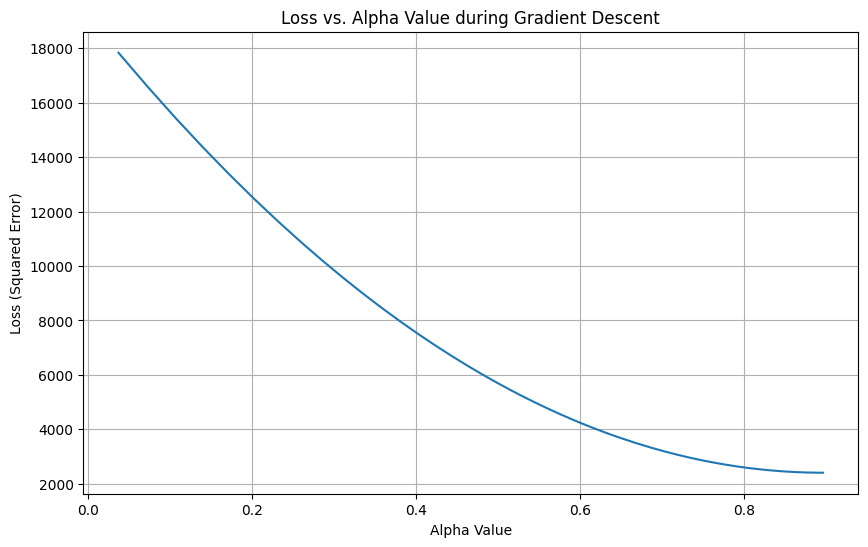

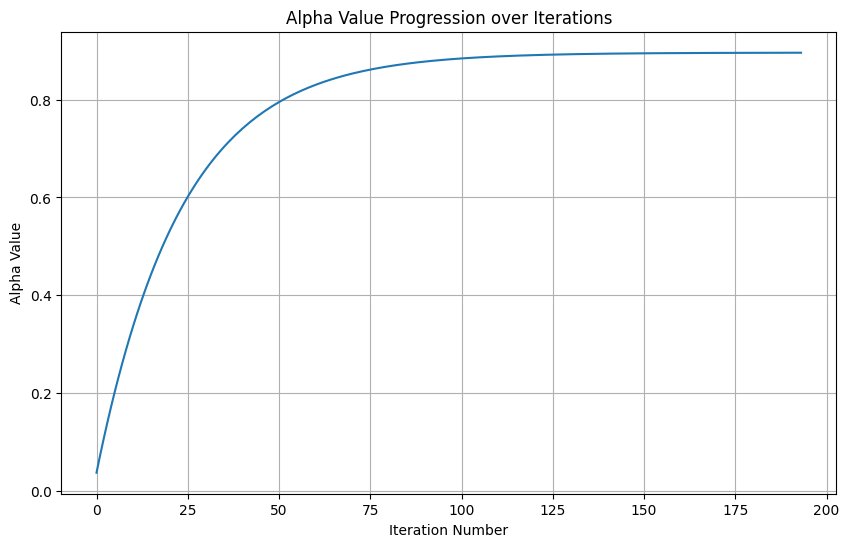

In [139]:
# Plot Loss over Alpha Value
plt.figure(figsize=(10, 6))
plt.plot(alphaHistory, lossHistory)
plt.xlabel("Alpha Value")
plt.ylabel("Loss (Squared Error)")
plt.title("Loss vs. Alpha Value during Gradient Descent")
plt.grid(True)
plt.show()

# Plot Alpha Progression over Iterations
plt.figure(figsize=(10, 6))
plt.plot(alphaHistory)
plt.xlabel("Iteration Number")
plt.ylabel("Alpha Value")
plt.title("Alpha Value Progression over Iterations")
plt.grid(True)
plt.show()

## **Visualización de Imágenes**

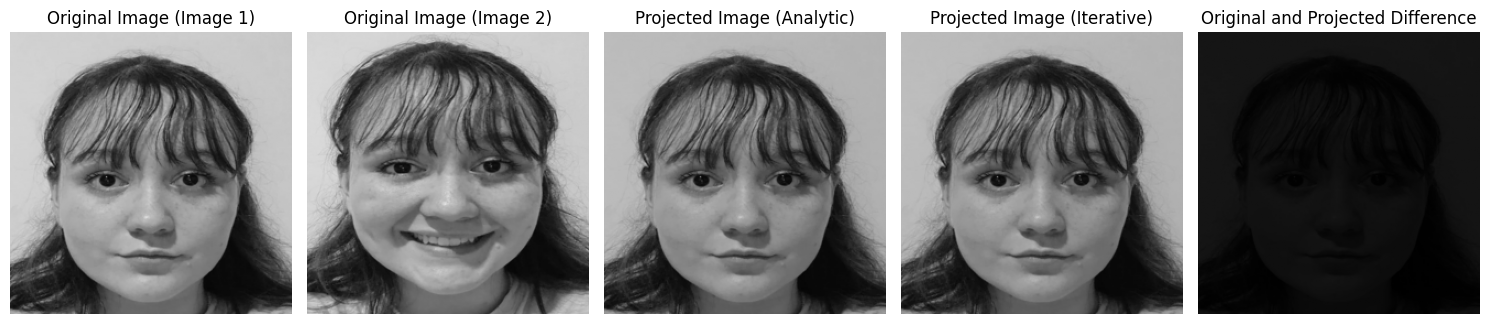

In [140]:
# --- Display Results ---
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(image1.reshape(256, 256), cmap='gray', vmin=0, vmax=1)
axes[0].set_title("Original Image (Image 1)")
axes[0].axis("off")

axes[1].imshow(image2.reshape(256, 256), cmap='gray', vmin=0, vmax=1)
axes[1].set_title("Original Image (Image 2)")
axes[1].axis("off")

axes[2].imshow(projectedImageAnalytic2D, cmap='gray', vmin=0, vmax=1)
axes[2].set_title("Projected Image (Analytic)")
axes[2].axis("off")

axes[3].imshow(projectedImageIterative2D, cmap='gray', vmin=0, vmax=1)
axes[3].set_title("Projected Image (Iterative)")
axes[3].axis("off")

# Calculate the difference between image1 and its projection onto image1
difference_image = image1.reshape(256, 256) - projectedImageIterative2D

# Display the difference image
axes[4].imshow(difference_image, cmap='gray', vmin=0, vmax=1) # Adjust range as needed
axes[4].set_title("Original and Projected Difference")
axes[4].axis("off")


plt.tight_layout()
plt.show()